# Regional Effects (unknown black-box function)

This guide provides a gentle overview of Regional Effect methods and introduces the `Effector` package. Regional Effects serve as a bridge between local and global feature effects. Recently, [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf) introduced a method to identify regions within the feature space that minimize feature interactions. Their approach focused on minimizing the interaction-related heterogeneity using ICE curves for a singular feature of interest. This methodology has been expanded to encompass ALE and SHAP Dependence Plots for multiple features of interest through [GADGET](https://arxiv.org/pdf/2306.00541.pdf).

In this tutorial, we demonstrate how to leverage `Effector` to pinpoint regions that minimize feature interactions. First, we show how to identify these regions based on ICE curves, as in [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf). Then, we illustrate the same procedure based on the heterogeneity of (RH)ALE plots. The former is achieved using the `RegionalPDP` class, while the latter with the `RegionalRHALE` class.

Future releases of `Effector` will include support for `RegionalSHAP` and expand the algorithms for multiple features of interest, as demonstrated in [GADGET](https://arxiv.org/pdf/2306.00541.pdf).

The tutorial is organized as follows:

- Introduction of the simulation example: We explore a simple linear scenario with subgroup-specific feature interactions, defined with both independent and dependent features.
- Modeling: We train a neural network on two datasets, one uncorrelated and the other correlated.
- PDP: Examining the influence of feature interactions and correlations.
- RHALE: Analyzing the impact of feature interactions and correlations.
- Regional Effects: Delving into RegionalPDP and RegionalALE.



In [61]:
import numpy as np
import effector
import keras
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(12345)

## Simulation example

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|-------|------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [62]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 500
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

We will use the following linear model with a subgroup-specific interaction term, $y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3 + \epsilon$ with $\epsilon \sim \mathcal{N}(0, 0.09)$. On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into two regions with respect to $x_3 = 0$. In this case only main effects remain in the two regions: 

<center>

| Feature |Region | Average Effect | Heterogeneity |
| --- | --- | --- |--- |
| $x_1$ | $x_3>0$| $3x_1$ | 0 |
| $x_1$ | $x_3\leq 0$| $-3x_1$ | 0 |
| $x_3$ | $x_3>0$| $x_3$ | 0 |
| $x_3$ | $x_3\leq 0$| $x_3$ | 0 |

</center>

Since $x_2$ does not have any influence (neither main nor interaction effect) on the target, the average effect and the heterogeneity of this feature are $0$ (globally and regionally).
Note that the average effect of $x_1$ cancels out on a global level and thus only considering the average global effect would suggest no influence of the feature on the target.

In [63]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.3)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

## Fit a Neural Network

We create a two-layer feedforward Neural Network, a weight decay of 0.01 for 100 epochs. We train two instances of this NN, one on the uncorrelated and one on the correlated setting. In both cases, the NN achieves a Mean Squared Error of about $0.17$ units.

In [64]:
# Train - Evaluate - Explain a neural network
model_uncor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_uncor.compile(optimizer=optimizer, loss="mse")
model_uncor.fit(X_uncor_train, Y_uncor_train, epochs=100)
model_uncor.evaluate(X_uncor_test, Y_uncor_test)

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 2.9988
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 1.9351
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 1.1397
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 0.6974
Epoch 5/100
16/16 [==============================] - 0s 884us/step - loss: 0.5631
Epoch 6/100
16/16 [==============================] - 0s 903us/step - loss: 0.4844
Epoch 7/100
16/16 [==============================] - 0s 950us/step - loss: 0.4282
Epoch 8/100
16/16 [==============================] - 0s 849us/step - loss: 0.4040
Epoch 9/100
16/16 [==============================] - 0s 864us/step - loss: 0.3807
Epoch 10/100
16/16 [==============================] - 0s 897us/step - loss: 0.3514
Epoch 11/100
16/16 [==============================] - 0s 999us/step - loss: 0.3719
Epoch 12/100
16/16 [==============================] - 0s 866us/step - loss: 0.3410
Epoch 13/100
16/16 [=

0.17182691395282745

In [65]:
model_cor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_cor.compile(optimizer=optimizer, loss="mse")
model_cor.fit(X_cor_train, Y_cor_train, epochs=100)
model_cor.evaluate(X_cor_test, Y_cor_test)

Epoch 1/100
16/16 [==============================] - 1s 940us/step - loss: 3.1880
Epoch 2/100
16/16 [==============================] - 0s 991us/step - loss: 1.0342
Epoch 3/100
16/16 [==============================] - 0s 882us/step - loss: 0.6690
Epoch 4/100
16/16 [==============================] - 0s 902us/step - loss: 0.4570
Epoch 5/100
16/16 [==============================] - 0s 802us/step - loss: 0.3160
Epoch 6/100
16/16 [==============================] - 0s 781us/step - loss: 0.2654
Epoch 7/100
16/16 [==============================] - 0s 781us/step - loss: 0.2489
Epoch 8/100
16/16 [==============================] - 0s 832us/step - loss: 0.2320
Epoch 9/100
16/16 [==============================] - 0s 794us/step - loss: 0.2190
Epoch 10/100
16/16 [==============================] - 0s 820us/step - loss: 0.2079
Epoch 11/100
16/16 [==============================] - 0s 865us/step - loss: 0.2036
Epoch 12/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1981
Epoch 13/100
16

0.1527336984872818

---
## PDP

Let's define some notation for the rest of the tutorial:

<center>

| Symbol                                                     | Description                                             |
|------------------------------------------------------------|---------------------------------------------------------|
| $f(\mathbf{x})$                                            | The black box model                                     |
| $x_s$                                                      | The feature of interest                                 |
| $x_c$                                                      | The remaining features, i.e., $\mathbf{x} = (x_s, x_c)$ |
| $\mathbf{x} = (x_s, x_c) = (x_1, x_2, ..., x_s, ..., x_D)$ | The input features                                      |
| $\mathbf{x}^{(i)} = (x_s^{(i)}, x_c^{(i)})$                | The $i$-th instance of the dataset                      |

</center>

The PDP is defined as **_the average of the model's output over the entire dataset, while varying the feature of interest._**:

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated using the training data: 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) =  \frac{1}{N} \sum_{j=1}^N ICE^i(x_s)$$

The PDP is simply the average over the underlying ICE curves (local effects) which visualize how the feature of interest influences the prediction of the ML model for each single instance. The ICE curves indicate (a) the heterogeneity of local effects and (b) the feature interactions. When the ICE curves are homogeneous (i.e., they share similar shape), then the PDP is close to the ICE curves and the feature interactions are weak. When the ICE curves are heterogeneous, then the PDP decline from the ICE curves and the impact of feature interactions is strong.

### Uncorrelated setting

By definition, PDPs treat the features as independent, therefore it is a good explanation method for the uncorrelated case.

#### What to expect

In the uncorrelated setting, we expect the following:

   * the average effect of $x_1$ to be $0$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$, which is either positive or negative depending on the value of $x_1^i$

Let's check it out the PDP using `effector`.

#### Global PDP

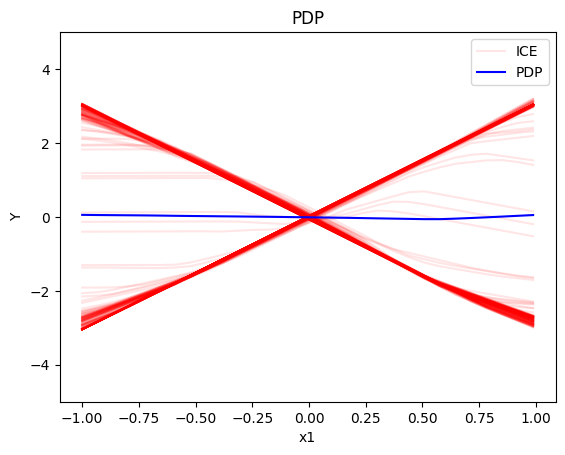

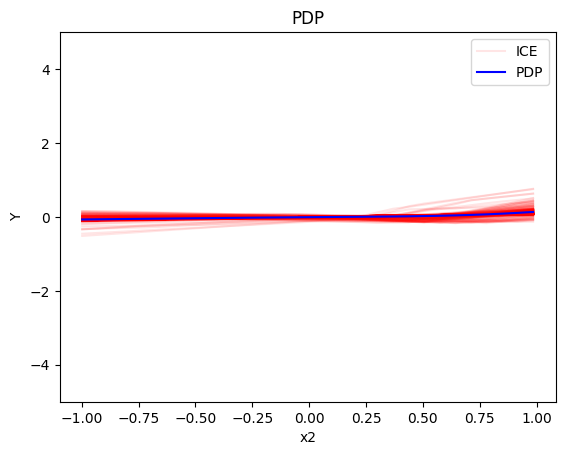

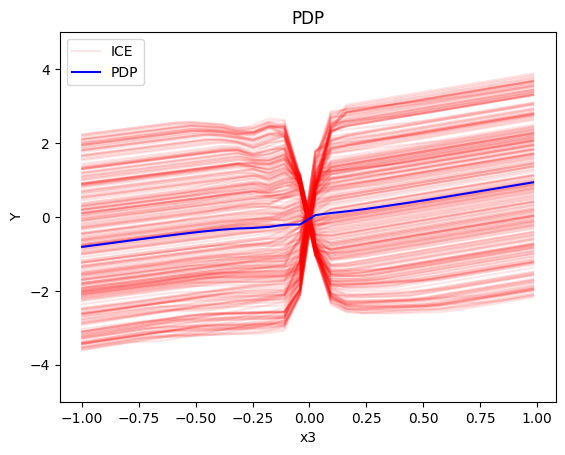

In [66]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

We expect that as expected:

* For $x_1$, we have two opposite linear effects that cancel out
  * when $x_3>0$ it is $3x_1$ 
  * when $x_3 \leq 0$, it is $-3x_1$
* For $x_2$ the effect is zero with almost zero heterogeneity (ice curves that deviate are due to bad fitting of the NN)
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ when $x_3 \leq 0$ and $x_3 + 3x_1^i$ when $x_3 > 0$
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ when $x_3 \leq 0$ and $x_3 - 3x_1^i$ when $x_3 > 0$

#### Regional PDP

Regional PDP will search for interpretable and distinct regions within the feature space such that the interaction-related heterogeneity is minimized within the regions. In the case of PDPs and ICE this means, that we minimize the heterogeneity of mean-centered ICE curves. This means that we group ICE curves with a similar shape, i.e., we find regions in which the instances within this regions show a similar influence on the prediction for the feature of interests, while this influence differs for other regions.

In our example, we expect that the algorithm will find two regions for $x_1$ (one for $x_1 \leq 0$ and one for $x_1 > 0$), two regions for $x_3$ (one for $x_1 \leq 0$ and one for $x_1 > 0$). For $x_2$ we expect that the algorithm will not find any subregion.

In [67]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


In [68]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.69 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.02, heter: 0.24 || nof_instances:    46 || weight: 0.46
        Node id: 2, name: x1 | x3  > 0.02, heter: 0.32 || nof_instances:    54 || weight: 0.54
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.69
        Level 1, heter: 0.28 || heter drop: 1.41 (83.31%)


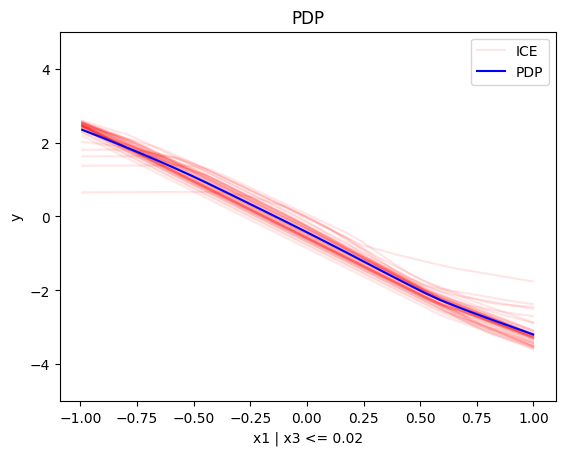

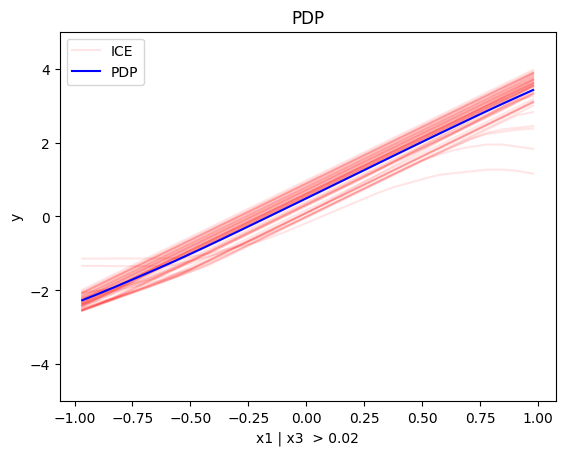

In [69]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", y_limits=[-5, 5])

In [70]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.91 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.91


In [71]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.78 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.18, heter: 0.66 || nof_instances:    34 || weight: 0.34
        Node id: 2, name: x3 | x1  > -0.18, heter: 1.00 || nof_instances:    66 || weight: 0.66
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.78
        Level 1, heter: 0.88 || heter drop: 0.90 (50.48%)


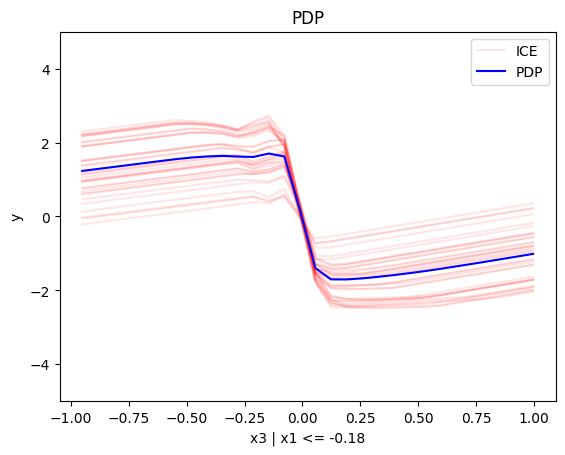

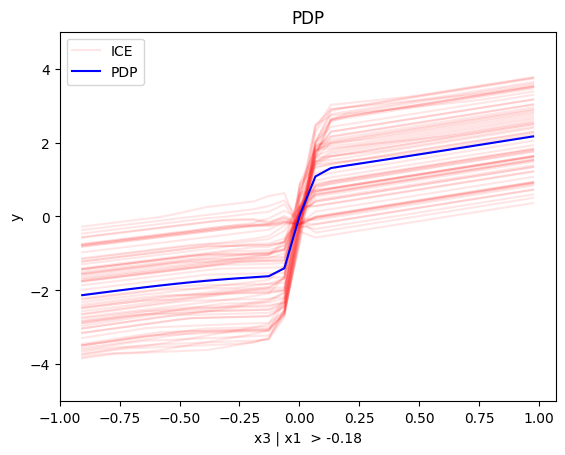

In [72]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

As expected:

* For $x_1$, the algorithm finds two regions, one for $x_1 \leq 0$ and one for $x_1 > 0$
  * when $x_3>0$ the effect is $3x_1$
  * when $x_3 \leq 0$, the effect is $-3x_1$
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting

As said above the PDP assumes feature independence. Therefore, it is *not* a good explanation method for the correlated case.

#### What to expect

If applying PDP to a correlated setting, it will treat the features as independent.
Therefore, in principle, we expect the same features effects as in the uncorrelated setting.
However, due to extrapolation to features values that have not been seen during training, we expect noisy estimation.

Since the PDP assumes feature independence, we can observe in the highly correlated setting the following artifact: $x_1$ and $x_3$ are highly positively correlated, therefore, the combination of small (high) $x_1$ and high (small) $x_3$ feature values is not available and thus has not been seen by the model during the training process. However, ICE curves and PDPs are visualized for the entire feature range of the feature of interest (e.g., $x_1$). Thus, we extrapolate with our model (here NN) into unseen or sparse regions of the feature space. This might lead to an osciliating behavior depending on the underlying chosen ML model. Therefore, we might receive heterogeneity of local effects (ICE curves) which are not caused by feature interactions but by extrapolation due to feature correlations. This behavior is especially visible for feature $x_1$ in our example.

#### Global PDP

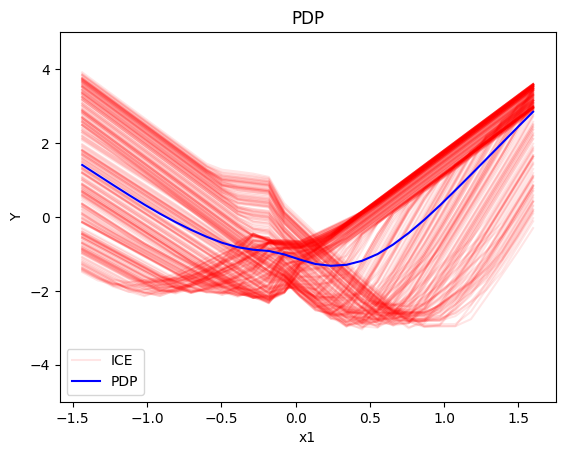

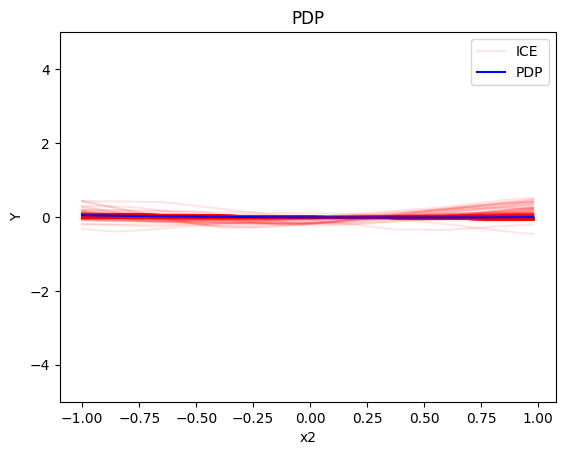

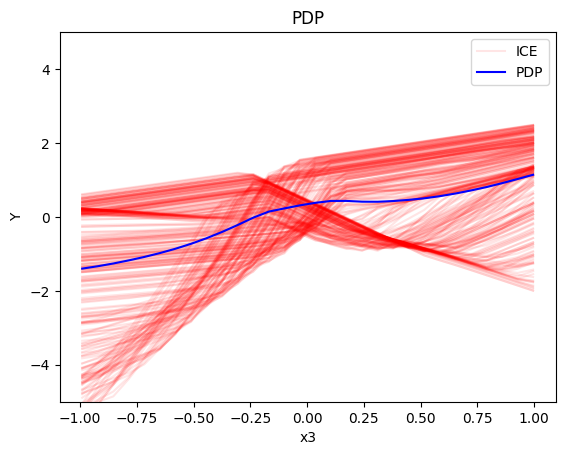

In [73]:
pdp = effector.PDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

As before:

* For $x_1$, we have two opposite linear effects that cancel out
  * when $x_3>0$ it is $3x_1$ 
  * when $x_3 \leq 0$, it is $-3x_1$
* For $x_2$ the effect is zero with almost zero heterogeneity (ice curves that deviate are due to bad fitting of the NN)
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ when $x_3 \leq 0$ and $x_3 + 3x_1^i$ when $x_3 > 0$
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ when $x_3 \leq 0$ and $x_3 - 3x_1^i$ when $x_3 > 0$
   
However, we should notice that due to extrapolation to unobserved regions:

   * the ICE effects of $x_1$ have a small plateau around $x_1=0$
   * the offset of the ICE effects of $x_3$ cover a larger range around zero than in the uncorrelated setting

#### Regional-PDP

In [74]:
regional_pdp = effector.RegionalPDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.4, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


In [75]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.27 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.24 || nof_instances:    53 || weight: 0.53
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.31 || nof_instances:    47 || weight: 0.47
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.27
        Level 1, heter: 0.28 || heter drop: 0.99 (78.29%)


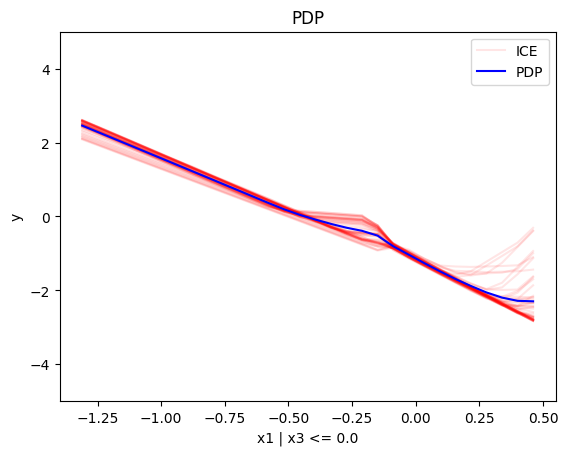

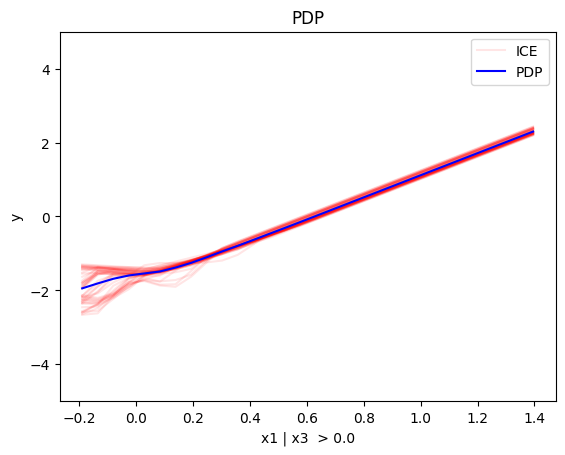

In [76]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [77]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.27 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.27


In [78]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.32 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.32


In [79]:
# regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
# regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

We observe that the extracted subregions are as expected, but the effects inside the subregions are noisy due to extrapolation.

For example, for $x_3$:
  * when $x_1>0$ the line is steep in the beginning, i.e. from $x_3=-0.3$ to $x_3=0.3$ and then it is flat
  * when $x_1<0$ the line is flat in the beginning, i.e. from $x_3=-1$ to $x_3=-0.1$ and then it is steep

## (RH)ALE

ALE defines the feature effect as *the integral of the partial derivative of the model's output with respect to the feature of interest*:

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z$$

The approximation is defined as:

$$\hat{\text{ALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]$$

where $k_{x_s}$ the index of the bin such that $z_{k_{x−1}} ≤ x_s < z_{k_x}$, $\mathcal{S}_k$ is the set of the instances lying at the $k$-th bin, i.e., $\mathcal{S}_k = \{ x^{(i)} : z_{k−1} \neq x^{(i)}_s < z_k \}$ and $\Delta x = \frac{x_{s, max} - x_{s, min}}{K}$. $\hat{\text{ALE}}(x_s)$ uses a Riemannian sum to approximate the integral of $\text{ALE}(x_s)$. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect of the feature of interest is estimated using the instances that fall in the bin. The average effect in each bin is called bin-effect. 

Robust and Heterogeneity-aware ALE (RHALE) is a variant of ALE, proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193). In their paper, they showed that RHALE has specific advantages over ALE: (a) it ensures on-distribution sampling (b) an unbiased estimation of the heterogeneity and (c) an optimal trade-off between bias and variance. These are achieved using an automated variable-size binning splitting approach: 

$$\hat{\text{RHALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{ \left | \mathcal{S}_k \right |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \frac{\partial f}{\partial x_s} (x_s^{(i)}, x_c^{(i)})$$

In our example, we will use the RHALE approximation with a fixed-size bin-splitting:

In [80]:
def model_uncor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_uncor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_cor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_cor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

### Uncorrelated setting

The ALE and RHALE approaches work well in both correlated and uncorrelated settings. 

#### What to expect

In the uncorrelated setting, we expect the following:

   * the average effect of $x_1$ to be $0$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. In contrast with the PDP plots, in (RH)ALE the heterogeneity is expressed only around $x_3=0$, where the value of ${\partial f}/{\partial x_3}$ depends on the value of $x_1^i$. Outside this region, the heterogeneity is zero.

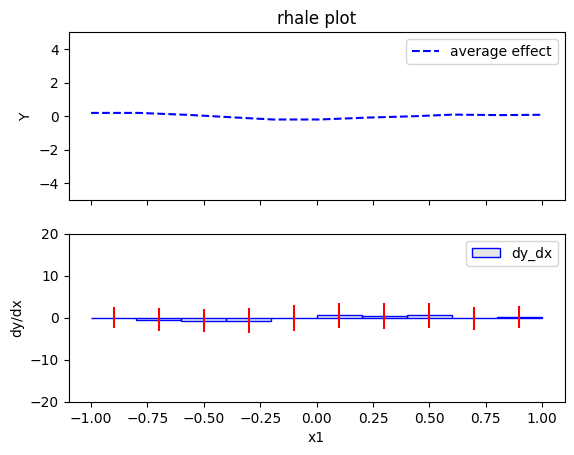

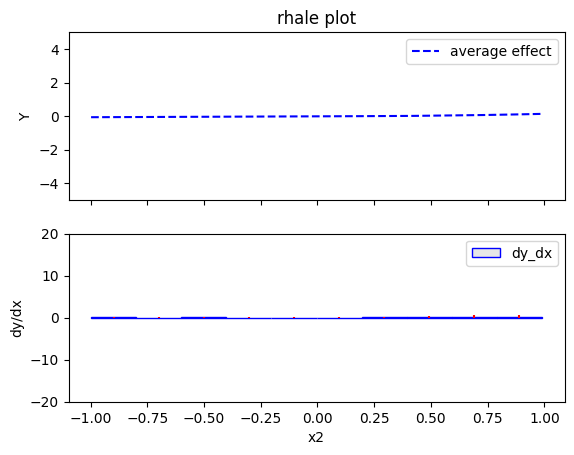

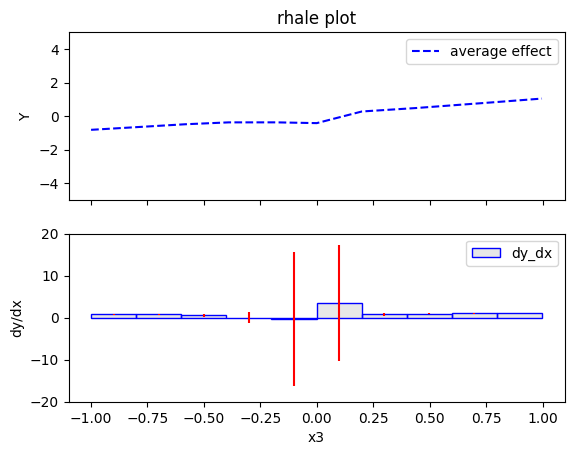

In [81]:
rhale = effector.RHALE(data=X_uncor_train, model=model_uncor, model_jac=model_uncor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-20, 20])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-20, 20])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-20, 20])

As expected:

* For $x_1$, we have a zero-average effect with a constant heterogeneity along the axis
* For $x_2$ the effect is zero with almost zero heterogeneity
* For $x_3$, the average effect is $x_3$ and the heterogeneity appears only around $x_3=0$


#### Regional ALE

The disadvantage of RHALE plot is that it does not reveal the type of heterogeneity. Therefore, Regional (RH)ALE plot can help identify the type of heterogeneity. Let's see that in practice:

In [82]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model_uncor, 
    model_jac= model_uncor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=11
)


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


In [83]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 5.52 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.01, heter: 0.57 || nof_instances:    56 || weight: 0.56
        Node id: 2, name: x1 | x3  > -0.01, heter: 0.75 || nof_instances:    44 || weight: 0.44
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 5.52
        Level 1, heter: 0.65 || heter drop: 4.87 (88.24%)


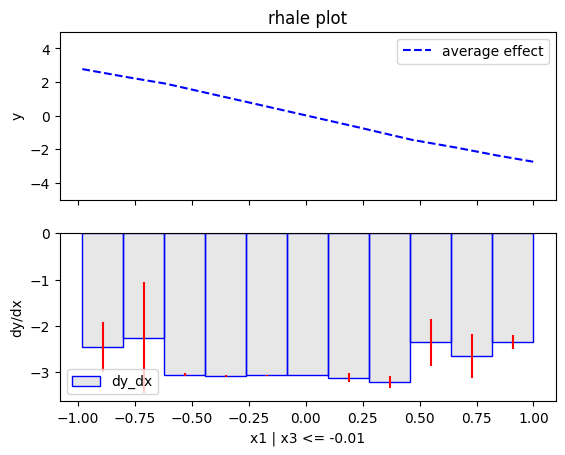

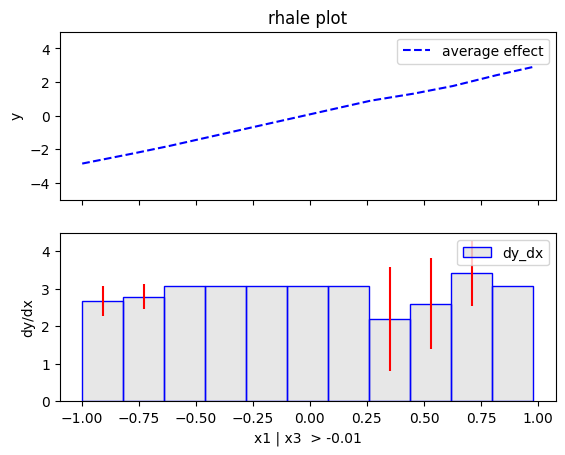

In [84]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [85]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.30 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.30


In [86]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 4.69 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 4.69


## Correlated setting

In [87]:
rhale = effector.RHALE(data=X_cor_train, model=model_cor, model_jac=model_cor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

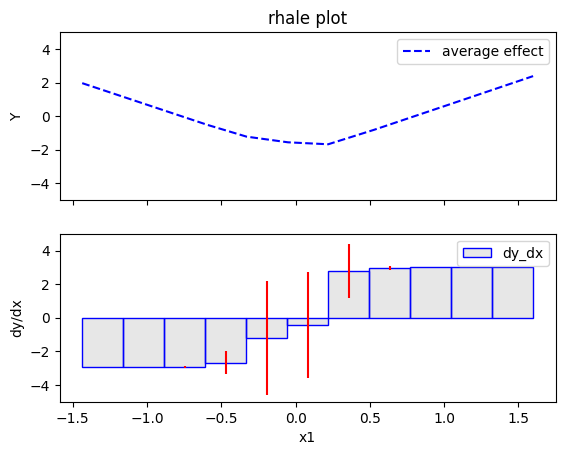

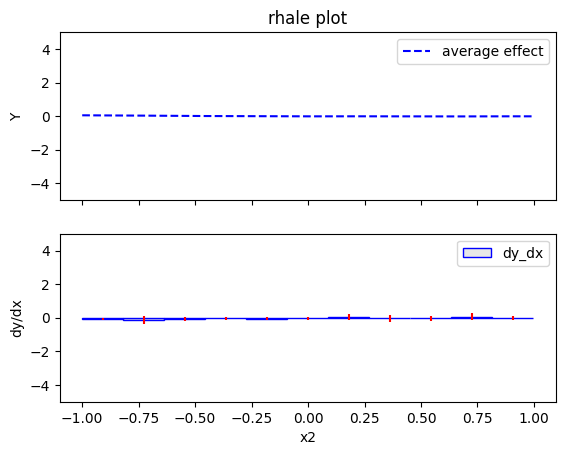

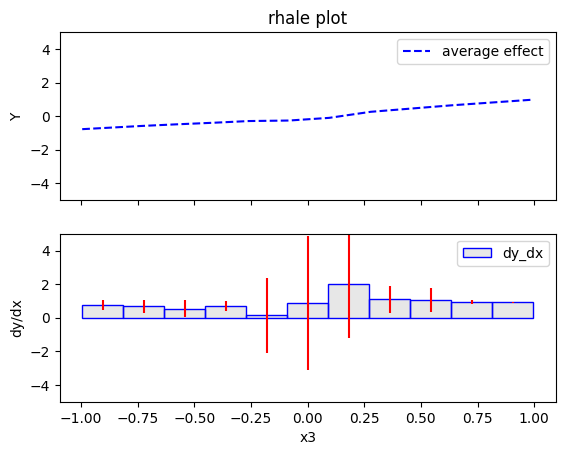

In [88]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

In [89]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model_cor, 
    model_jac= model_cor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=11
)

100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


In [90]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 2.03 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.02, heter: 0.67 || nof_instances:    47 || weight: 0.47
        Node id: 2, name: x1 | x3  > 0.02, heter: 0.58 || nof_instances:    53 || weight: 0.53
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 2.03
        Level 1, heter: 0.62 || heter drop: 1.41 (69.26%)


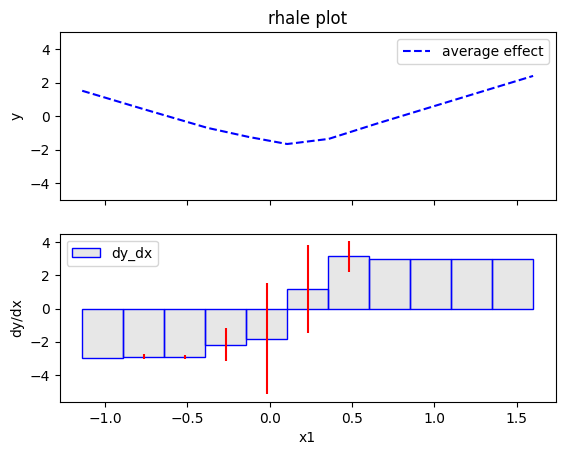

In [91]:
regional_rhale.plot(feature=0, node_idx=0, heterogeneity="std", centering=True, y_limits=[-5, 5])


In [92]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.13 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.13


In [93]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.36 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.36
